# Notebook for plotting synthetic in situ profiles

In [ ]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pickle as p

import datetime as datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd
import os
import copy as cp

import py3dcore_h4c as py3dcore_h4c

import py3dcore_h4c.fluxplot as fp

import warnings
warnings.filterwarnings('ignore')

import logging

logging.basicConfig(level=logging.INFO)
logging.getLogger("heliosat.spice").setLevel("WARNING")
logging.getLogger("heliosat.spacecraft").setLevel("WARNING")

#print(sns.__version__)

In [7]:
path = 'output/solo06092022_heeq_1024_restrP_3/'

filepath = fp.loadpickle(path, number = -1)

In [ ]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 6, 3, tzinfo=datetime.timezone.utc)

tt_s = t_s.strftime('%Y-%m-%d-%H')
print(tt_s)

fp.insituprofiles(observer='psp', date=tt_s, start=t_s, end=t_e, filepath=filepath, 
                  best=False, mean=True, save_fig=True, legend=True, fixed=None)

#t = [t_s + datetime.timedelta(hours=i) for i in range(96)]
#end = t_s + datetime.timedelta(hours=96)
#tt, pos_temp,traj = fp.getpos('psp', tt_s, t_s, end)

In [ ]:
t_launch = datetime.datetime(2022, 9, 5, 18, 45, tzinfo=datetime.timezone.utc) # launch time assumed at CME impact at PSP at 14.72 Rs

t_s = datetime.datetime(2022, 9, 7, 8, tzinfo=datetime.timezone.utc) 
t_e = datetime.datetime(2022, 9, 8, 3, tzinfo=datetime.timezone.utc)

start = t_s + datetime.timedelta(hours=1)

t_fit = [
        datetime.datetime(2022, 9, 7, 9, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 15, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 7, 20, tzinfo=datetime.timezone.utc),
        datetime.datetime(2022, 9, 8, 2, tzinfo=datetime.timezone.utc)
     ]

fp.fullinsitu(observer='solo', t_fit=t_fit, start=t_s, end=t_e, filepath=filepath, 
              custom_data='solo_2022sep.p', best=False, ensemble=True, mean=True, save_fig=True, legend=True, fixed=None)

<class 'numpy.ndarray'>


INFO:py3dcore_h4c.fluxplot:Plotting run with mean parameters.
INFO:py3dcore_h4c.fitter.base:Using custom datafile: solo_2022sep.p


In [2]:
###### overwrite initial values that we already know or can estimate more closely


overwrite = {
    "cme_longitude": {
        "maximum": 165,
        "minimum": 155
    },
    "cme_aspect_ratio": {
        "maximum": 3.5,
        "minimum": 2.5
    }
}

# initialize model

n = 1024 # number of runs
start = datetime.datetime.now() # starttime of ICME
# start = datetime.datetime(2022, 9, 5, 17, 0, 0)

model_obj = py3dcore_h4c.ToroidalModel(start, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [3]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()

# these can be accessed by the following

i = 1 # parameter index

model_obj.iparams_arr[:, i]

array([158.7454 , 164.50714, 162.31995, ..., 157.9735 , 164.24396,
       164.71059], dtype=float32)

In [4]:
# we set a timedelta in hours and propagate each of the runs

timedelta = 24
end = start + datetime.timedelta(hours=timedelta)

model_obj.propagator(end)

# the state parameters of parameter i at that given time are then given by

model_obj.sparams_arr[:,i]

array([0.17785354, 0.231178  , 0.15459776, ..., 0.15615831, 0.16843113,
       0.18735053], dtype=float32)

In [5]:
# an output array needs to be created beforehand, then we can simulate the magnetic field at a given position

pos = np.array([0.4,0,0]) 

outa = np.empty((n,3))
model_obj.simulator_mag(pos,out=outa)

In [6]:
outa[outa !=0]

array([], dtype=float64)

In [7]:
# dts = [datetime.datetime.now() + datetime.timedelta(hours=i) for i in range(96)]
dts = [start + datetime.timedelta(hours=i) for i in range(96)]
pos = [np.array([1.0,0,0]) for _ in dts]
outa = model_obj.simulator(dts, pos)

In [8]:
A=np.array(outa[0])
print(np.where(A!=0))
A[A==0] = np.nan

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


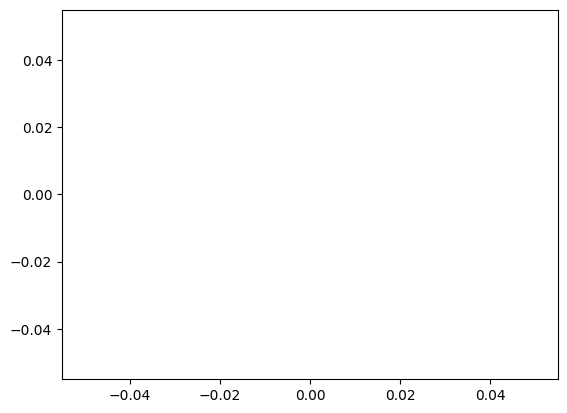

In [9]:
plt.plot(A[:, 306, :])

In [10]:
np.where(A != 0)

(array([ 0,  0,  0, ..., 95, 95, 95]),
 array([   0,    0,    0, ..., 1023, 1023, 1023]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [22]:
wf_arr=model_obj.visualize_shape(306, 30)

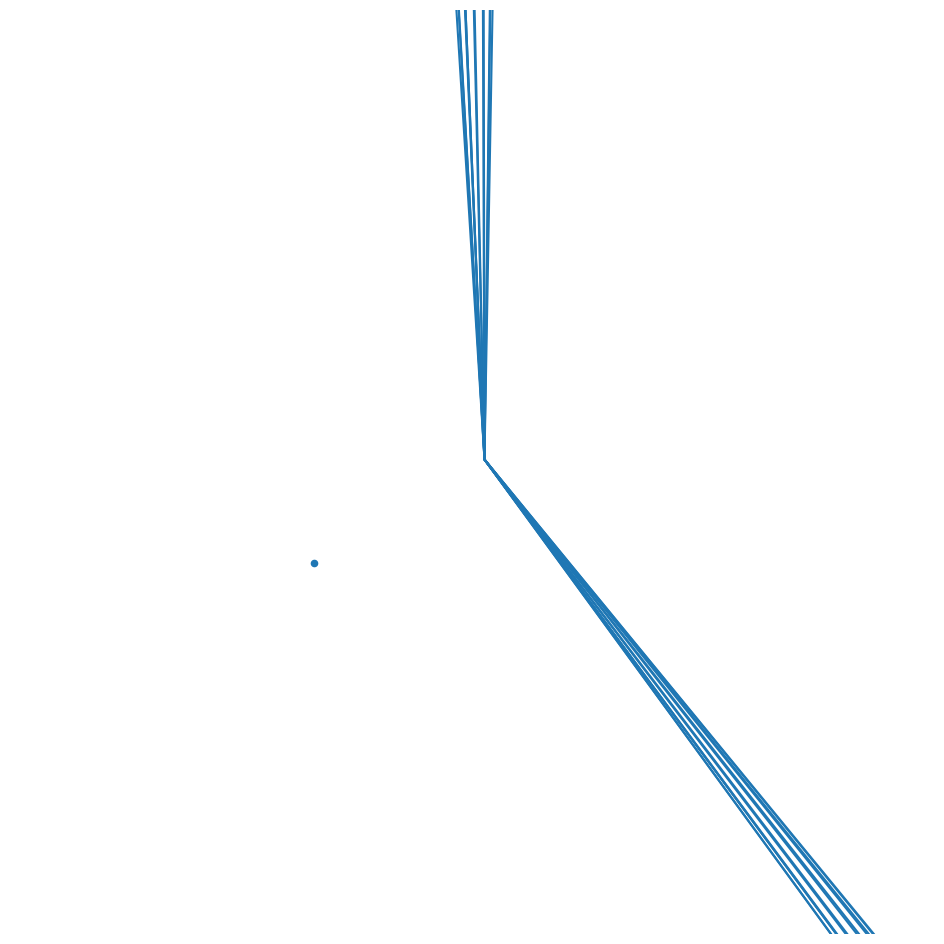

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(*wf_arr.T)
ax.scatter(1,0,0)
ax.set_axis_off()
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(elev=25, azim=35)